MPU6050 FLIP DETECTION - RANDOM FOREST CLASSIFIER

Dataset shape: (1000, 7)

Class distribution:
label
1    500
0    500
Name: count, dtype: int64

0 = Not Flipping, 1 = Flipping

Features after engineering: ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'label', 'acc_magnitude', 'gyro_magnitude', 'gravity_deviation', 'roll', 'pitch']

Training samples: 800
Testing samples: 200

TRAINING RANDOM FOREST CLASSIFIER

✓ Model training complete!

MODEL EVALUATION

Accuracy: 1.0000 (100.00%)

Classification Report:
              precision    recall  f1-score   support

Not Flipping       1.00      1.00      1.00       100
    Flipping       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Confusion Matrix:
[[100   0]
 [  0 100]]

FEATURE IMPORTANCE

               feature  importance
7      gyro_magnitude    0.459452
8   gravity_deviation    0.188058
2  

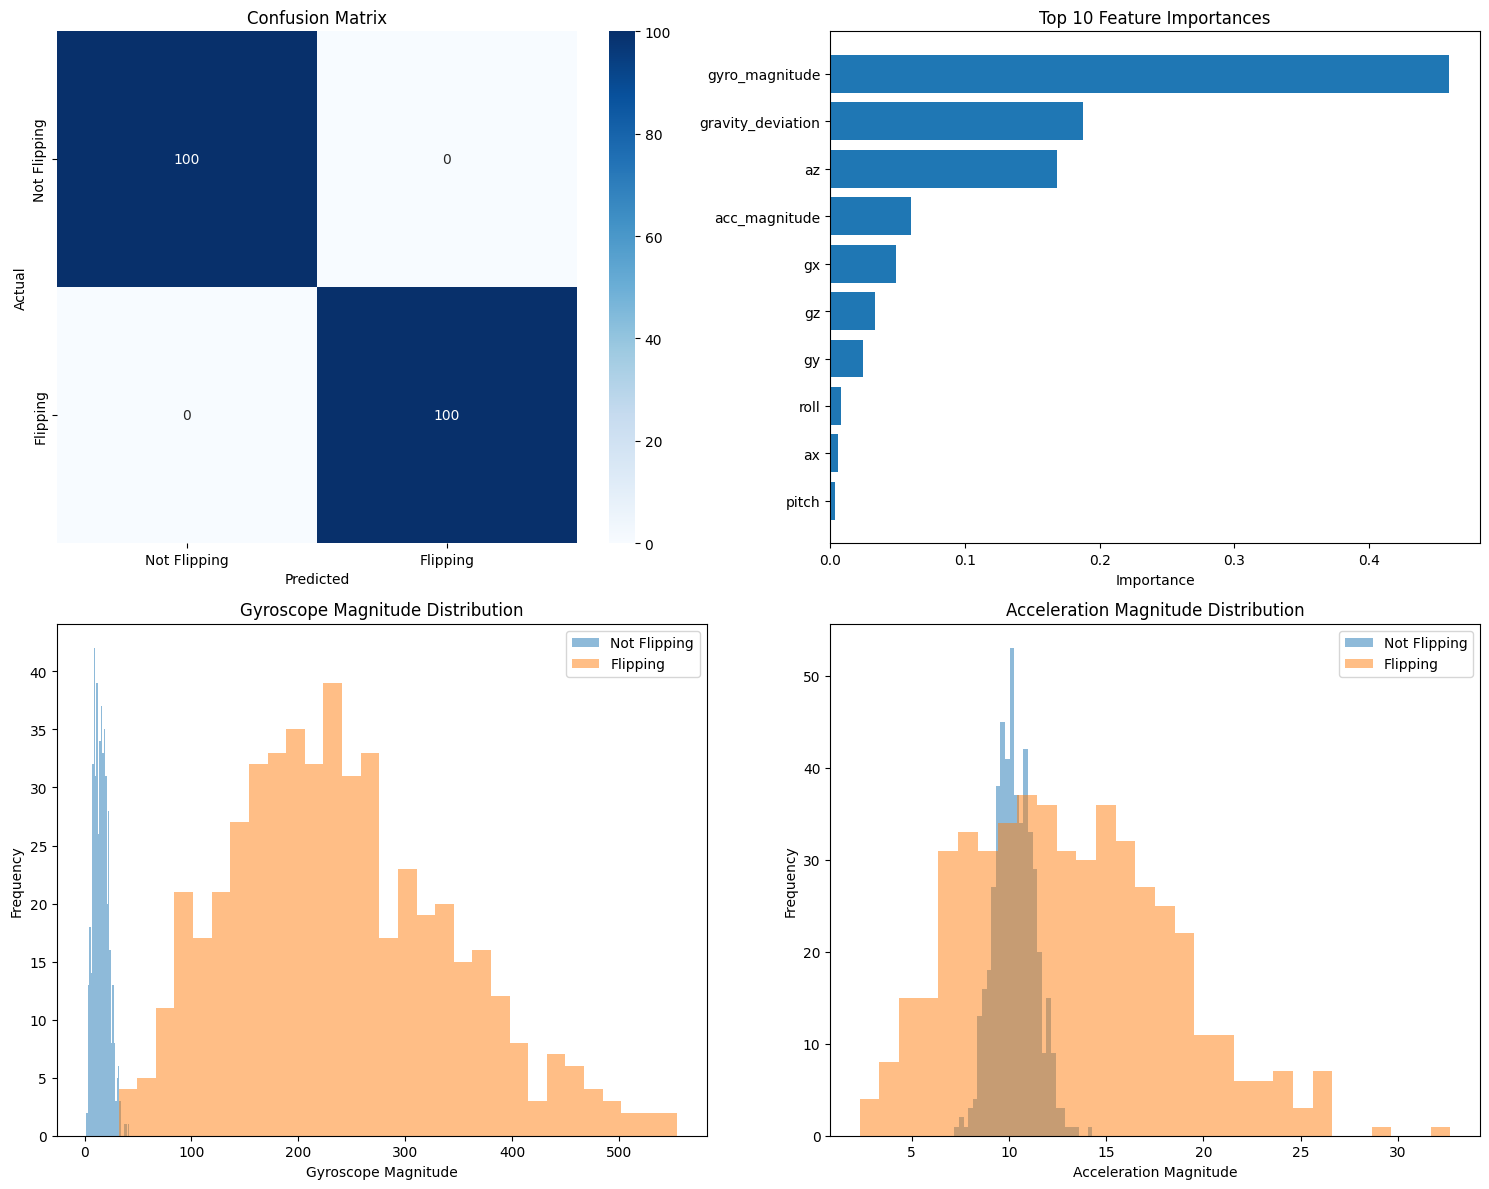


REAL-TIME PREDICTION TEST

Test Case 1:
  Input: {'ax': 0.5, 'ay': 0.3, 'az': 9.7, 'gx': 5, 'gy': 3, 'gz': 2}
  Prediction: NOT FLIPPING
  Confidence: Not Flipping=100.00%, Flipping=0.00%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Test Case 2:
  Input: {'ax': 5, 'ay': 6, 'az': 2, 'gx': 180, 'gy': 170, 'gz': 160}
  Prediction: FLIPPING
  Confidence: Not Flipping=0.67%, Flipping=99.33%

✓ MODEL READY FOR DEPLOYMENT!


In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# MPU6050 FLIP DETECTION USING RANDOM FOREST CLASSIFIER
# ============================================================================
# This notebook detects "flipping" vs "not flipping" based on MPU6050 sensor data
# MPU6050 provides: Accelerometer (ax, ay, az) and Gyroscope (gx, gy, gz) data

# ============================================================================
# 1. GENERATE SAMPLE DATA (Replace with your actual MPU6050 data)
# ============================================================================

def generate_sample_mpu6050_data(n_samples=1000):
    """
    Generate synthetic MPU6050 data for demonstration
    In production, replace this with your actual sensor readings
    """
    np.random.seed(42)

    # Normal movement (not flipping) - small variations
    normal_samples = n_samples // 2
    normal_data = {
        'ax': np.random.normal(0, 2, normal_samples),      # slight x-axis acceleration
        'ay': np.random.normal(0, 2, normal_samples),      # slight y-axis acceleration
        'az': np.random.normal(9.8, 1, normal_samples),    # gravity on z-axis
        'gx': np.random.normal(0, 10, normal_samples),     # small rotation x
        'gy': np.random.normal(0, 10, normal_samples),     # small rotation y
        'gz': np.random.normal(0, 10, normal_samples),     # small rotation z
        'label': [0] * normal_samples  # 0 = not flipping
    }

    # Flipping movement - large rotations and acceleration changes
    flip_samples = n_samples - normal_samples
    flip_data = {
        'ax': np.random.normal(0, 8, flip_samples),        # high x acceleration
        'ay': np.random.normal(0, 8, flip_samples),        # high y acceleration
        'az': np.random.normal(0, 8, flip_samples),        # varying gravity
        'gx': np.random.normal(0, 150, flip_samples),      # high rotation x
        'gy': np.random.normal(0, 150, flip_samples),      # high rotation y
        'gz': np.random.normal(0, 150, flip_samples),      # high rotation z
        'label': [1] * flip_samples  # 1 = flipping
    }

    # Combine datasets
    df_normal = pd.DataFrame(normal_data)
    df_flip = pd.DataFrame(flip_data)
    df = pd.concat([df_normal, df_flip], ignore_index=True)

    # Shuffle
    df = df.sample(frac=1).reset_index(drop=True)

    return df

# ============================================================================
# 2. FEATURE ENGINEERING
# ============================================================================

def engineer_features(df):
    """
    Create additional features from raw MPU6050 data
    """
    # Magnitude of acceleration vector
    df['acc_magnitude'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)

    # Magnitude of gyroscope vector
    df['gyro_magnitude'] = np.sqrt(df['gx']**2 + df['gy']**2 + df['gz']**2)

    # Deviation from gravity (should be ~9.8 when not flipping)
    df['gravity_deviation'] = np.abs(df['az'] - 9.8)

    # Roll and pitch approximations
    df['roll'] = np.arctan2(df['ay'], df['az']) * 180 / np.pi
    df['pitch'] = np.arctan2(-df['ax'], np.sqrt(df['ay']**2 + df['az']**2)) * 180 / np.pi

    return df

# ============================================================================
# 3. LOAD AND PREPARE DATA
# ============================================================================

print("=" * 70)
print("MPU6050 FLIP DETECTION - RANDOM FOREST CLASSIFIER")
print("=" * 70)

# Generate sample data (replace with: df = pd.read_csv('your_mpu6050_data.csv'))
df = generate_sample_mpu6050_data(n_samples=1000)

print(f"\nDataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\n0 = Not Flipping, 1 = Flipping")

# Engineer features
df = engineer_features(df)

print(f"\nFeatures after engineering: {df.columns.tolist()}")

# ============================================================================
# 4. PREPARE TRAINING DATA
# ============================================================================

# Features and target
X = df.drop('label', axis=1)
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# ============================================================================
# 5. TRAIN RANDOM FOREST CLASSIFIER
# ============================================================================

print("\n" + "=" * 70)
print("TRAINING RANDOM FOREST CLASSIFIER")
print("=" * 70)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

print("\n✓ Model training complete!")

# ============================================================================
# 6. EVALUATE MODEL
# ============================================================================

print("\n" + "=" * 70)
print("MODEL EVALUATION")
print("=" * 70)

# Predictions
y_pred = rf_model.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Flipping', 'Flipping']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ============================================================================
# 7. FEATURE IMPORTANCE
# ============================================================================

print("\n" + "=" * 70)
print("FEATURE IMPORTANCE")
print("=" * 70)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n", feature_importance)

# ============================================================================
# 8. VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xticklabels(['Not Flipping', 'Flipping'])
axes[0, 0].set_yticklabels(['Not Flipping', 'Flipping'])

# Feature Importance
top_features = feature_importance.head(10)
axes[0, 1].barh(top_features['feature'], top_features['importance'])
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('Top 10 Feature Importances')
axes[0, 1].invert_yaxis()

# Gyroscope magnitude distribution
axes[1, 0].hist(df[df['label']==0]['gyro_magnitude'], alpha=0.5, label='Not Flipping', bins=30)
axes[1, 0].hist(df[df['label']==1]['gyro_magnitude'], alpha=0.5, label='Flipping', bins=30)
axes[1, 0].set_xlabel('Gyroscope Magnitude')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Gyroscope Magnitude Distribution')
axes[1, 0].legend()

# Acceleration magnitude distribution
axes[1, 1].hist(df[df['label']==0]['acc_magnitude'], alpha=0.5, label='Not Flipping', bins=30)
axes[1, 1].hist(df[df['label']==1]['acc_magnitude'], alpha=0.5, label='Flipping', bins=30)
axes[1, 1].set_xlabel('Acceleration Magnitude')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Acceleration Magnitude Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# ============================================================================
# 9. REAL-TIME PREDICTION FUNCTION
# ============================================================================

def predict_flip(ax, ay, az, gx, gy, gz):
    """
    Predict if device is flipping based on single MPU6050 reading

    Parameters:
    - ax, ay, az: accelerometer readings
    - gx, gy, gz: gyroscope readings

    Returns:
    - prediction: 0 (not flipping) or 1 (flipping)
    - probability: confidence score
    """
    # Create feature dictionary
    features = {
        'ax': ax, 'ay': ay, 'az': az,
        'gx': gx, 'gy': gy, 'gz': gz
    }

    # Engineer features
    features['acc_magnitude'] = np.sqrt(ax**2 + ay**2 + az**2)
    features['gyro_magnitude'] = np.sqrt(gx**2 + gy**2 + gz**2)
    features['gravity_deviation'] = abs(az - 9.8)
    features['roll'] = np.arctan2(ay, az) * 180 / np.pi
    features['pitch'] = np.arctan2(-ax, np.sqrt(ay**2 + az**2)) * 180 / np.pi

    # Convert to array in correct order
    feature_array = np.array([[features[col] for col in X.columns]])

    # Scale
    feature_scaled = scaler.transform(feature_array)

    # Predict
    prediction = rf_model.predict(feature_scaled)[0]
    probability = rf_model.predict_proba(feature_scaled)[0]

    return prediction, probability

# ============================================================================
# 10. TEST REAL-TIME PREDICTION
# ============================================================================

print("\n" + "=" * 70)
print("REAL-TIME PREDICTION TEST")
print("=" * 70)

# Test with sample readings
test_cases = [
    {"ax": 0.5, "ay": 0.3, "az": 9.7, "gx": 5, "gy": 3, "gz": 2},  # Normal
    {"ax": 5, "ay": 6, "az": 2, "gx": 180, "gy": 170, "gz": 160}    # Flipping
]

for i, reading in enumerate(test_cases, 1):
    pred, prob = predict_flip(**reading)
    print(f"\nTest Case {i}:")
    print(f"  Input: {reading}")
    print(f"  Prediction: {'FLIPPING' if pred == 1 else 'NOT FLIPPING'}")
    print(f"  Confidence: Not Flipping={prob[0]:.2%}, Flipping={prob[1]:.2%}")

print("\n" + "=" * 70)
print("✓ MODEL READY FOR DEPLOYMENT!")
print("=" * 70)

ULTRASONIC SENSOR CAR COUNTER - ML MODEL

Dataset shape: (1000, 7)

Car count distribution:
car_count
0    161
1    160
2    176
3    168
4    172
5    163
Name: count, dtype: int64

Features after engineering: ['distance', 'distance_variance', 'num_peaks', 'avg_gap', 'min_distance', 'max_distance', 'car_count', 'distance_range', 'normalized_variance', 'gap_density', 'distance_category']

Sample data:
      distance  distance_variance  num_peaks     avg_gap  min_distance  \
0  2272.527288          13.964354          3  376.151493    274.141858   
1  2891.179096          17.034899          3  273.741510    221.213260   
2   404.954932           1.999305          0    0.000000    404.954932   
3  2232.198905          22.749334          3  291.806644    314.080339   
4  2891.496278          15.148787          4  347.371991    228.839511   
5  1522.991326          13.987377          1  238.957818    270.181747   
6  3004.848841          33.281233          3  344.088052    281.756240   
7  

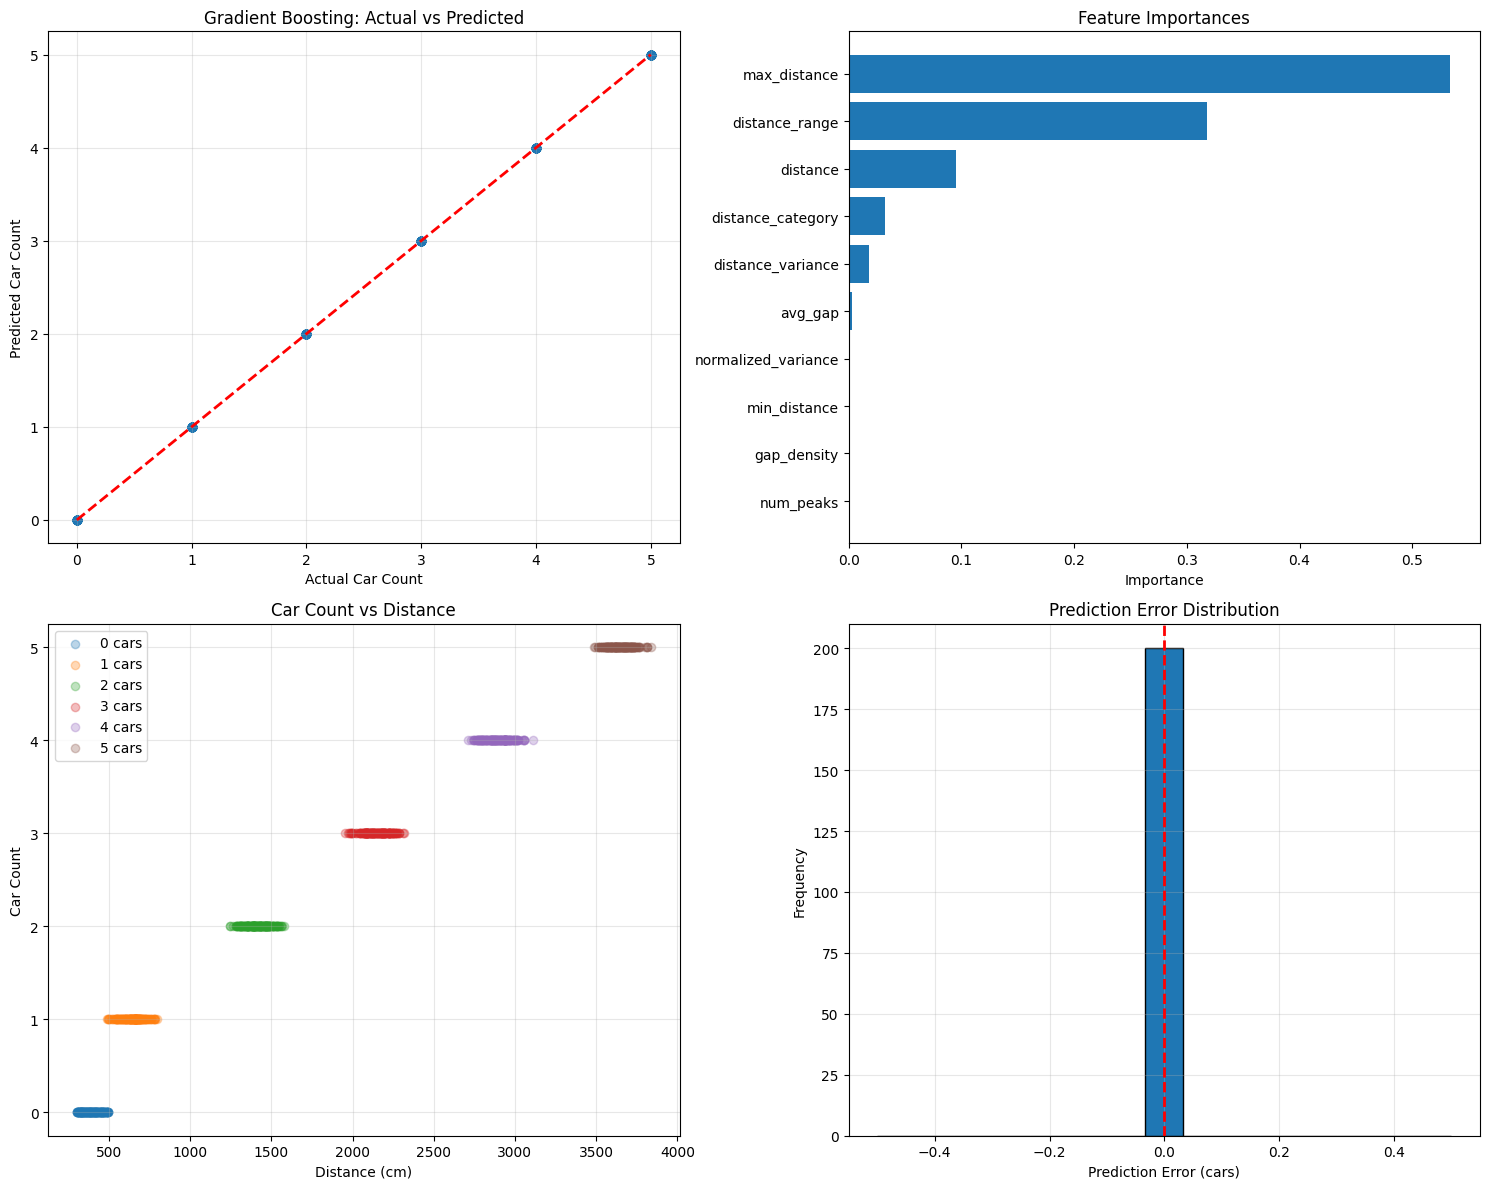


REAL-TIME PREDICTION TEST

Test Case 1:
  Distance: 450cm, Variance: 2, Peaks: 0
  Predicted Cars: 0
  Confidence: High

Test Case 2:
  Distance: 650cm, Variance: 8, Peaks: 1
  Predicted Cars: 1
  Confidence: Low

Test Case 3:
  Distance: 1500cm, Variance: 18, Peaks: 3
  Predicted Cars: 2
  Confidence: High

Test Case 4:
  Distance: 2500cm, Variance: 28, Peaks: 4
  Predicted Cars: 4
  Confidence: High

✓ MODEL READY FOR DEPLOYMENT!

Integration Tips:
- Collect sensor readings over a time window (e.g., 2-3 seconds)
- Calculate variance and detect peaks in the distance measurements
- Feed aggregated features into the model for car counting
- Consider using a moving average filter to smooth sensor noise


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# ULTRASONIC SENSOR CAR COUNTER
# ============================================================================
# This notebook detects and counts how many cars are in front of each other
# using ultrasonic distance sensor data

# ============================================================================
# 1. GENERATE SAMPLE DATA (Replace with your actual sensor data)
# ============================================================================

def generate_ultrasonic_car_data(n_samples=1000):
    """
    Generate synthetic ultrasonic sensor data for car counting

    Features:
    - distance: current distance reading (cm)
    - distance_variance: variance in recent readings
    - num_peaks: number of distance peaks (gaps between cars)
    - avg_gap: average gap size
    - min_distance: minimum distance in window
    - max_distance: maximum distance in window

    Target:
    - car_count: number of cars detected
    """
    np.random.seed(42)

    data = []

    for _ in range(n_samples):
        # Randomly determine number of cars (0-5)
        num_cars = np.random.randint(0, 6)

        if num_cars == 0:
            # No cars - large distance, low variance
            distance = np.random.uniform(300, 500)
            distance_variance = np.random.uniform(0, 5)
            num_peaks = 0
            avg_gap = 0
            min_distance = distance
            max_distance = distance + 10
        else:
            # Cars present
            # Each car is roughly 4-5m long, with 2-4m gaps
            car_length = 450  # 4.5m average
            gap_length = 300  # 3m average gap

            # Base distance to first car
            first_car_distance = np.random.uniform(100, 300)

            # Total distance = first car + (num_cars * car_length) + ((num_cars-1) * gap_length)
            distance = first_car_distance + (num_cars * car_length) + ((num_cars - 1) * gap_length)
            distance += np.random.normal(0, 50)  # Add noise

            # More cars = more variance from multiple reflections
            distance_variance = np.random.uniform(5 + num_cars * 2, 15 + num_cars * 5)

            # Number of peaks corresponds to gaps between cars
            num_peaks = max(0, num_cars - 1 + np.random.randint(-1, 2))

            # Average gap between cars
            avg_gap = gap_length + np.random.normal(0, 50)

            # Min/max distances in measurement window
            min_distance = first_car_distance + np.random.uniform(-20, 20)
            max_distance = distance + np.random.uniform(-50, 50)

        data.append({
            'distance': max(0, distance),
            'distance_variance': max(0, distance_variance),
            'num_peaks': max(0, num_peaks),
            'avg_gap': max(0, avg_gap),
            'min_distance': max(0, min_distance),
            'max_distance': max(0, max_distance),
            'car_count': num_cars
        })

    return pd.DataFrame(data)

# ============================================================================
# 2. ADDITIONAL FEATURE ENGINEERING
# ============================================================================

def engineer_features(df):
    """
    Create additional features from ultrasonic sensor data
    """
    # Distance range
    df['distance_range'] = df['max_distance'] - df['min_distance']

    # Normalized variance (variance relative to distance)
    df['normalized_variance'] = df['distance_variance'] / (df['distance'] + 1)

    # Gap density (peaks per unit distance)
    df['gap_density'] = df['num_peaks'] / (df['distance'] + 1) * 1000

    # Distance bins (categorize distance ranges)
    df['distance_category'] = pd.cut(df['distance'],
                                      bins=[0, 200, 500, 1000, 5000],
                                      labels=[0, 1, 2, 3]).astype(int)

    return df

# ============================================================================
# 3. LOAD AND PREPARE DATA
# ============================================================================

print("=" * 70)
print("ULTRASONIC SENSOR CAR COUNTER - ML MODEL")
print("=" * 70)

# Generate sample data (replace with: df = pd.read_csv('your_ultrasonic_data.csv'))
df = generate_ultrasonic_car_data(n_samples=1000)

print(f"\nDataset shape: {df.shape}")
print(f"\nCar count distribution:")
print(df['car_count'].value_counts().sort_index())

# Engineer features
df = engineer_features(df)

print(f"\nFeatures after engineering: {df.columns.tolist()}")
print(f"\nSample data:")
print(df.head(10))

# ============================================================================
# 4. PREPARE TRAINING DATA
# ============================================================================

# Features and target
X = df.drop('car_count', axis=1)
y = df['car_count']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# ============================================================================
# 5. TRAIN MODELS
# ============================================================================

print("\n" + "=" * 70)
print("TRAINING MODELS")
print("=" * 70)

# Random Forest Regressor
print("\n1. Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
print("   ✓ Random Forest training complete!")

# Gradient Boosting Regressor
print("\n2. Training Gradient Boosting Regressor...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
print("   ✓ Gradient Boosting training complete!")

# ============================================================================
# 6. EVALUATE MODELS
# ============================================================================

print("\n" + "=" * 70)
print("MODEL EVALUATION")
print("=" * 70)

# Predictions
rf_pred = np.round(rf_model.predict(X_test_scaled)).astype(int)
gb_pred = np.round(gb_model.predict(X_test_scaled)).astype(int)

# Ensure predictions are non-negative
rf_pred = np.maximum(0, rf_pred)
gb_pred = np.maximum(0, gb_pred)

# Metrics for Random Forest
print("\nRANDOM FOREST REGRESSOR:")
print(f"  Mean Absolute Error: {mean_absolute_error(y_test, rf_pred):.4f}")
print(f"  Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, rf_pred)):.4f}")
print(f"  R² Score: {r2_score(y_test, rf_pred):.4f}")
print(f"  Exact Match Accuracy: {(rf_pred == y_test).mean():.4f} ({(rf_pred == y_test).mean()*100:.2f}%)")

# Metrics for Gradient Boosting
print("\nGRADIENT BOOSTING REGRESSOR:")
print(f"  Mean Absolute Error: {mean_absolute_error(y_test, gb_pred):.4f}")
print(f"  Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, gb_pred)):.4f}")
print(f"  R² Score: {r2_score(y_test, gb_pred):.4f}")
print(f"  Exact Match Accuracy: {(gb_pred == y_test).mean():.4f} ({(gb_pred == y_test).mean()*100:.2f}%)")

# Select best model
rf_mae = mean_absolute_error(y_test, rf_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)

if rf_mae < gb_mae:
    best_model = rf_model
    best_name = "Random Forest"
    best_pred = rf_pred
else:
    best_model = gb_model
    best_name = "Gradient Boosting"
    best_pred = gb_pred

print(f"\n✓ Best Model: {best_name}")

# ============================================================================
# 7. FEATURE IMPORTANCE
# ============================================================================

print("\n" + "=" * 70)
print("FEATURE IMPORTANCE")
print("=" * 70)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n", feature_importance)

# ============================================================================
# 8. VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Actual vs Predicted
axes[0, 0].scatter(y_test, best_pred, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Car Count')
axes[0, 0].set_ylabel('Predicted Car Count')
axes[0, 0].set_title(f'{best_name}: Actual vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

# Feature Importance
axes[0, 1].barh(feature_importance['feature'], feature_importance['importance'])
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('Feature Importances')
axes[0, 1].invert_yaxis()

# Car count distribution by distance
for count in range(6):
    subset = df[df['car_count'] == count]
    axes[1, 0].scatter(subset['distance'], [count]*len(subset), alpha=0.3, label=f'{count} cars')
axes[1, 0].set_xlabel('Distance (cm)')
axes[1, 0].set_ylabel('Car Count')
axes[1, 0].set_title('Car Count vs Distance')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Prediction error distribution
errors = best_pred - y_test
axes[1, 1].hist(errors, bins=15, edgecolor='black')
axes[1, 1].set_xlabel('Prediction Error (cars)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Prediction Error Distribution')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 9. REAL-TIME PREDICTION FUNCTION
# ============================================================================

def count_cars(distance, distance_variance, num_peaks, avg_gap, min_distance, max_distance):
    """
    Count number of cars based on ultrasonic sensor readings

    Parameters:
    - distance: current distance reading (cm)
    - distance_variance: variance in recent readings
    - num_peaks: number of distance peaks detected
    - avg_gap: average gap size
    - min_distance: minimum distance in measurement window
    - max_distance: maximum distance in measurement window

    Returns:
    - car_count: estimated number of cars
    - confidence: prediction confidence
    """
    # Create feature dictionary
    features = {
        'distance': distance,
        'distance_variance': distance_variance,
        'num_peaks': num_peaks,
        'avg_gap': avg_gap,
        'min_distance': min_distance,
        'max_distance': max_distance
    }

    # Engineer features
    features['distance_range'] = max_distance - min_distance
    features['normalized_variance'] = distance_variance / (distance + 1)
    features['gap_density'] = num_peaks / (distance + 1) * 1000

    # Distance category
    if distance <= 200:
        features['distance_category'] = 0
    elif distance <= 500:
        features['distance_category'] = 1
    elif distance <= 1000:
        features['distance_category'] = 2
    else:
        features['distance_category'] = 3

    # Convert to array in correct order
    feature_array = np.array([[features[col] for col in X.columns]])

    # Scale
    feature_scaled = scaler.transform(feature_array)

    # Predict
    prediction = best_model.predict(feature_scaled)[0]
    car_count = max(0, int(np.round(prediction)))

    # Estimate confidence based on feature values
    if distance > 500 and distance_variance < 10:
        confidence = "High" if car_count == 0 else "Low"
    elif num_peaks >= car_count - 1 and num_peaks <= car_count + 1:
        confidence = "High"
    else:
        confidence = "Medium"

    return car_count, confidence

# ============================================================================
# 10. TEST REAL-TIME PREDICTION
# ============================================================================

print("\n" + "=" * 70)
print("REAL-TIME PREDICTION TEST")
print("=" * 70)

# Test with sample readings
test_cases = [
    {"distance": 450, "distance_variance": 2, "num_peaks": 0, "avg_gap": 0,
     "min_distance": 445, "max_distance": 455},  # No cars

    {"distance": 650, "distance_variance": 8, "num_peaks": 1, "avg_gap": 300,
     "min_distance": 150, "max_distance": 700},  # 1-2 cars

    {"distance": 1500, "distance_variance": 18, "num_peaks": 3, "avg_gap": 320,
     "min_distance": 180, "max_distance": 1550},  # 3-4 cars

    {"distance": 2500, "distance_variance": 28, "num_peaks": 4, "avg_gap": 310,
     "min_distance": 200, "max_distance": 2600},  # 5 cars
]

for i, reading in enumerate(test_cases, 1):
    count, conf = count_cars(**reading)
    print(f"\nTest Case {i}:")
    print(f"  Distance: {reading['distance']}cm, Variance: {reading['distance_variance']}, Peaks: {reading['num_peaks']}")
    print(f"  Predicted Cars: {count}")
    print(f"  Confidence: {conf}")

print("\n" + "=" * 70)
print("✓ MODEL READY FOR DEPLOYMENT!")
print("=" * 70)
print("\nIntegration Tips:")
print("- Collect sensor readings over a time window (e.g., 2-3 seconds)")
print("- Calculate variance and detect peaks in the distance measurements")
print("- Feed aggregated features into the model for car counting")
print("- Consider using a moving average filter to smooth sensor noise")